In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scienceplots as _

plt.style.use("ieee")  # Comment out if not supported

# Evaporation Modeling (Penman's Equation vs. Pan Coefficient)

## Penman's Equation

$$
\begin{aligned}
  & E_0 = (0.015 + 0.00042T + 10^{-6}z) (0.8R_s - 40 + 2.5Fu (T-T_d)) \\
  & \text{$T$ is the daily mean temperature (°C), $z$ is the elevation (m), $R_s$ is the solar irradiance, } \\
  & \text{$F = 1 - 8.7 \cdot 10^-5 z$, $u$ is the windspeed at $2$m, and $T_d$ is the dewpoint temperature (°C).}
\end{aligned}
$$

## Pan Coefficient

$$P = 0.8$$


## Iowa Enviromental Mesnoet Data

https://mesonet.agron.iastate.edu/request/daily.phtml?network=AZ_ASOS

NOTE: As of 7/14/2023, we're using 0.0001 for trace reports instead of blank/empty values

PGA_2005_2020 is to match with solar radiation data, wich is 01/01/2005 - 12/31/2020

Query details: Arizona ASOS, PAGE MUNI, all data, 01/01/2003 - 01/01/2023, UTC, CSV, no latitude/longitude, no elevation, blank/empty values, Routine & Specials

Exact API query: https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=PGA&data=all&year1=2003&month1=1&day1=1&year2=2023&month2=1&day2=1&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=empty&direct=yes&report_type=3&report_type=4


In [3]:
SURFACE_AREA = 19991.22
ELEVATION = 1815
LATITUDE = 36.33385606273248
CATCHMENT_AREA = 482970.15  # (m^2), from loading GEOJSON to http://geojson.io/

pga_df = utils.load_mesonet(
    "/Users/quinnouyang/Desktop/Work-ish/CERG/Bodaway Gap/Water Optimization/dynamics_model/PGA_2005_2020.csv"
)

### Pan Data


In [4]:
# https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg
pan_m_df = pd.DataFrame(
    {
        "month": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "evap": [
            0.00,
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            0.00,
        ],
    }
)

pan_m_df["est"] = (
    0.8 * pan_m_df["evap"] * 25.4 / 30.437
)  # in/month -> mm/day (using approximate mean of days/month)

## Photovoltaic Geographical Information System (PVGIS) Solar Radiation Data

https://re.jrc.ec.europa.eu/pvg_tools/en/

PVGIS-ERA5, 2005-2020, Fixed, 0, 0, no PV, CSV

- G(i): Global irradiance on the inclined plane (plane of the array) (W/m2)
- H_sun: Sun height (degree)
- T2m: 2-m air temperature (degree Celsius)
- WS10m: 10-m total wind speed (m/s)
- Int: 1 means solar radiation values are reconstructed

CSV Header Info: https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/pvgis-tools/hourly-radiation_en


In [5]:
irr_df = utils.load_pvgis(
    "Water Optimization/dynamics_model/Curve_Radiation_2005_2020.csv"
)

In [6]:
# IDK WHAT THIS IS BUT IT BROKE THINGS
# temp_mm_df = get_mean(pga_df, "valid", ["tmpc"], "M")  # Monthly mean temperature
# temp_ym_df = get_mean(pga_df, "valid", ["tmpc"], "Y")  # Annual mean temperature
# temp_yr_df = get_range(pga_df, "valid", ["tmpc"], "Y")  # Annual temperature range


# irr_ym = 210 + 1.8 * LATITUDE - 0.06 * LATITUDE**2  # Annual mean irradiance
# irr_yr_df = get_range(pga_df, "valid", ["smps"], "Y")
# irr_yr_df["smps"] *= 2.5 * (1 - 8.7 * 10**-5 * ELEVATION)

# irr_mm = irr_yr_df * (temp_mm_df - temp_ym_df) / temp_yr_df

# pga_mr_df = get_range(pga_df, "valid", ["tmpc"], "M")

# print(pga_mr_df)

## Evaporation Estimations


### Monthly


In [7]:
pga_m_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "M")
irr_m_df = utils.get_mean(irr_df, "time", ["G(i)"], "M")

res_m_df = pd.merge(
    pga_m_df,
    irr_m_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

res_m_df["est"] = res_m_df.apply(
    lambda row: utils.get_evaporation_rate(
        row["tmpc"], row["dwpc"], ELEVATION, row["G(i)"], row["smps"]
    ),
    axis=1,
)

res_m_mean_df = res_m_df["est"].groupby(res_m_df["month"]).mean()
# print("Penman's Equation")
# print(res_m_mean_df)
# print("Pan Coefficient")
# print(pan_m_df["est"])

# print("% Diff to Pan")
# print(
#     np.abs(pan_m_df["est"].to_numpy() - res_m_mean_df.to_numpy())
#     * 100
#     / pan_m_df["est"]
# )

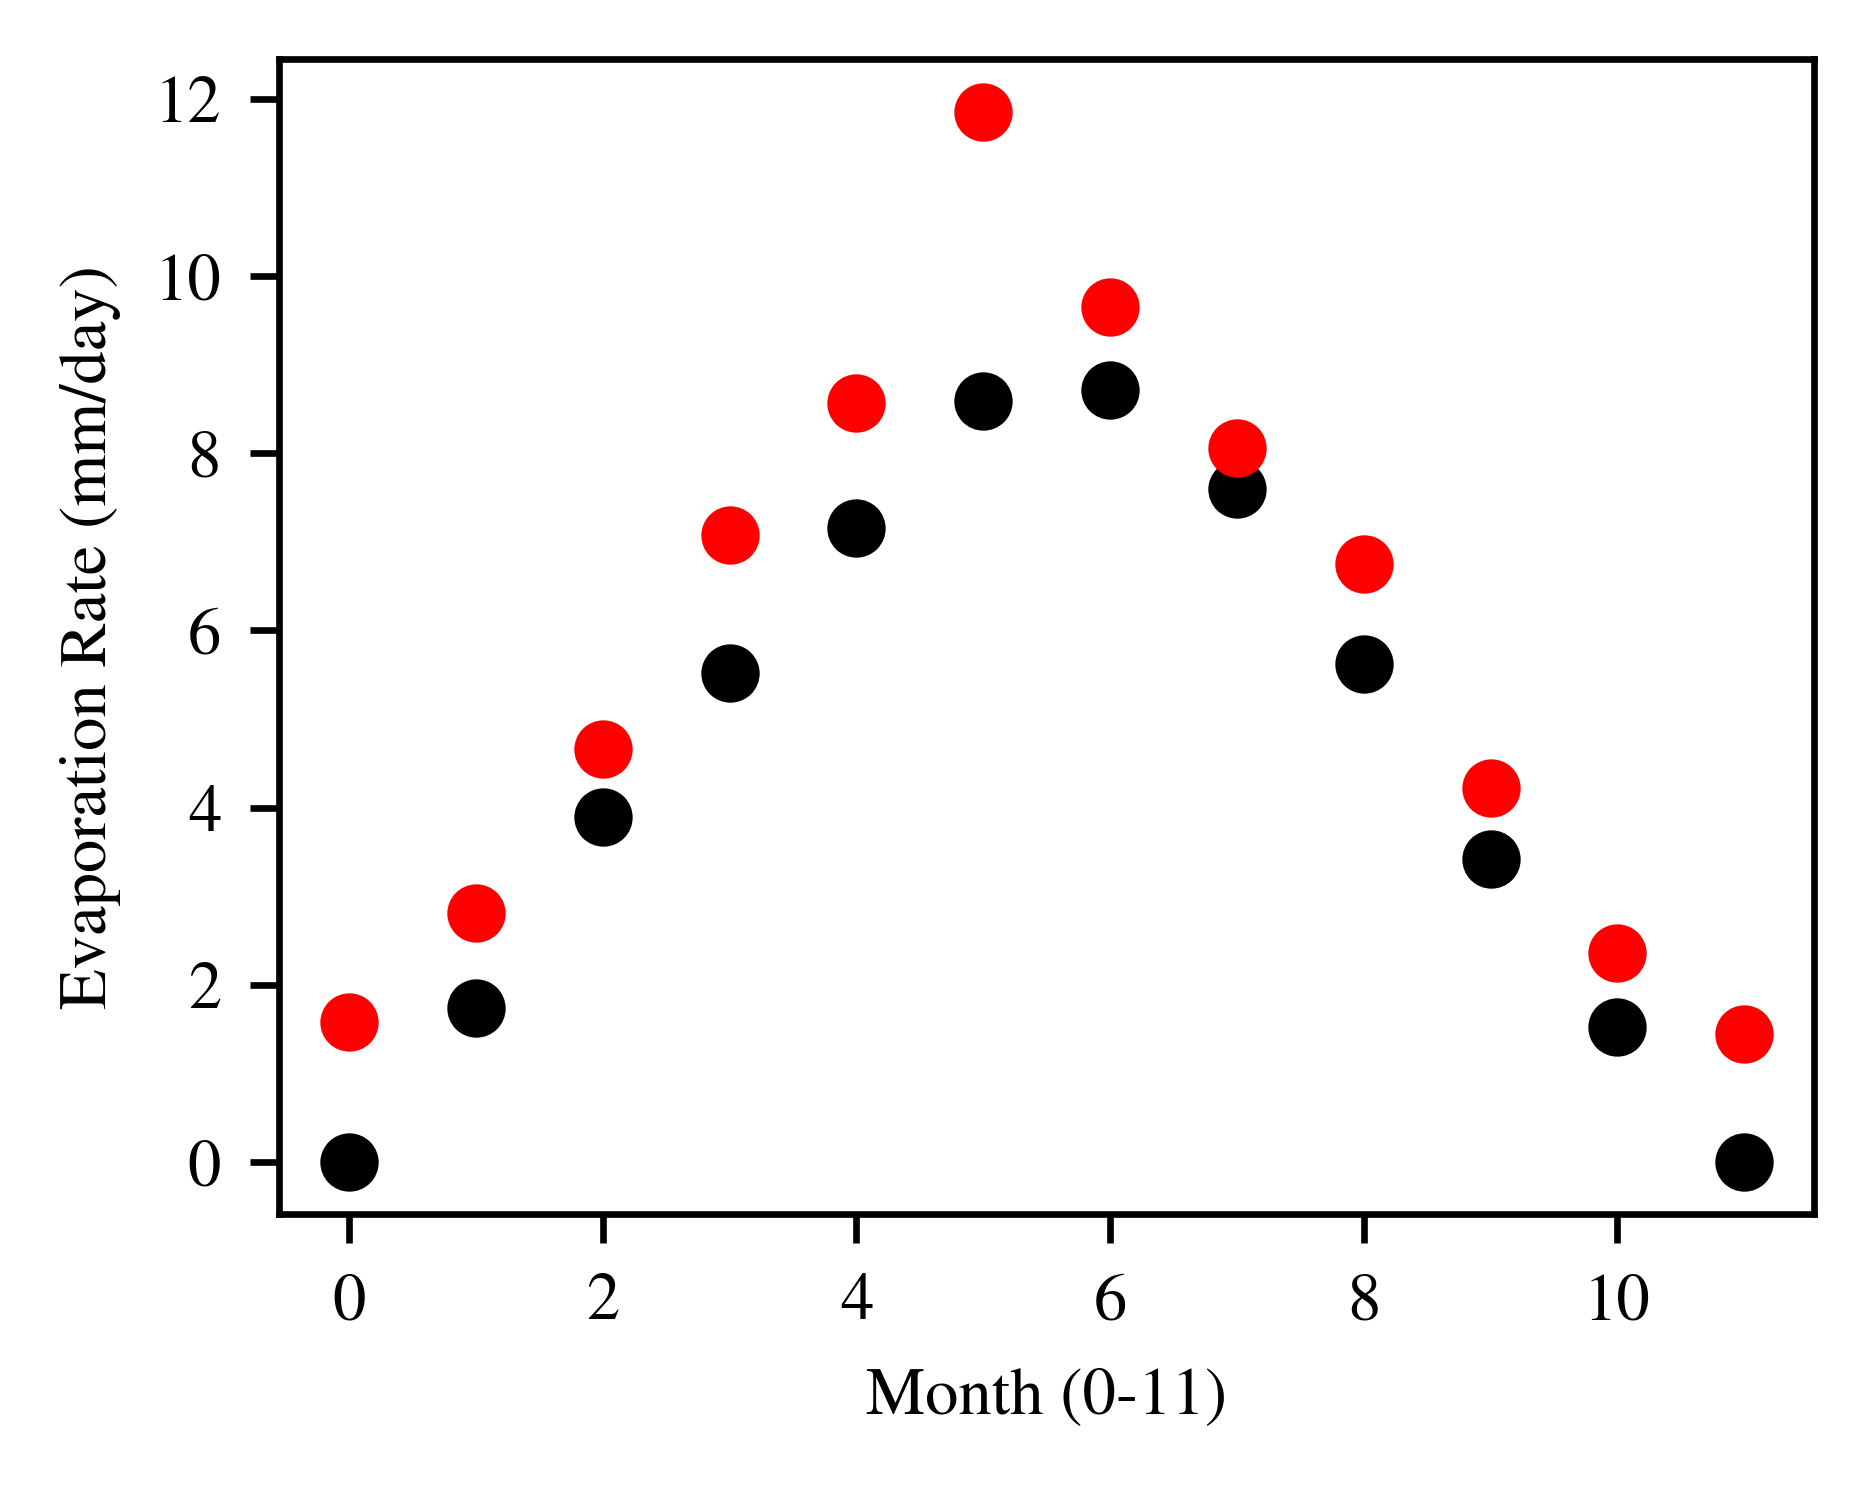

In [8]:
plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["est"].to_numpy(), "o")
plt.plot(res_m_mean_df.to_numpy(), "o")

## Curve Fitting


Fitted Parameters:  [ 8.68919818e-03 -4.12849150e-03  1.69750748e-05  5.11087694e-01
  6.60858637e+01 -6.07279595e+03 -1.03917413e+03  6.78645069e-02]


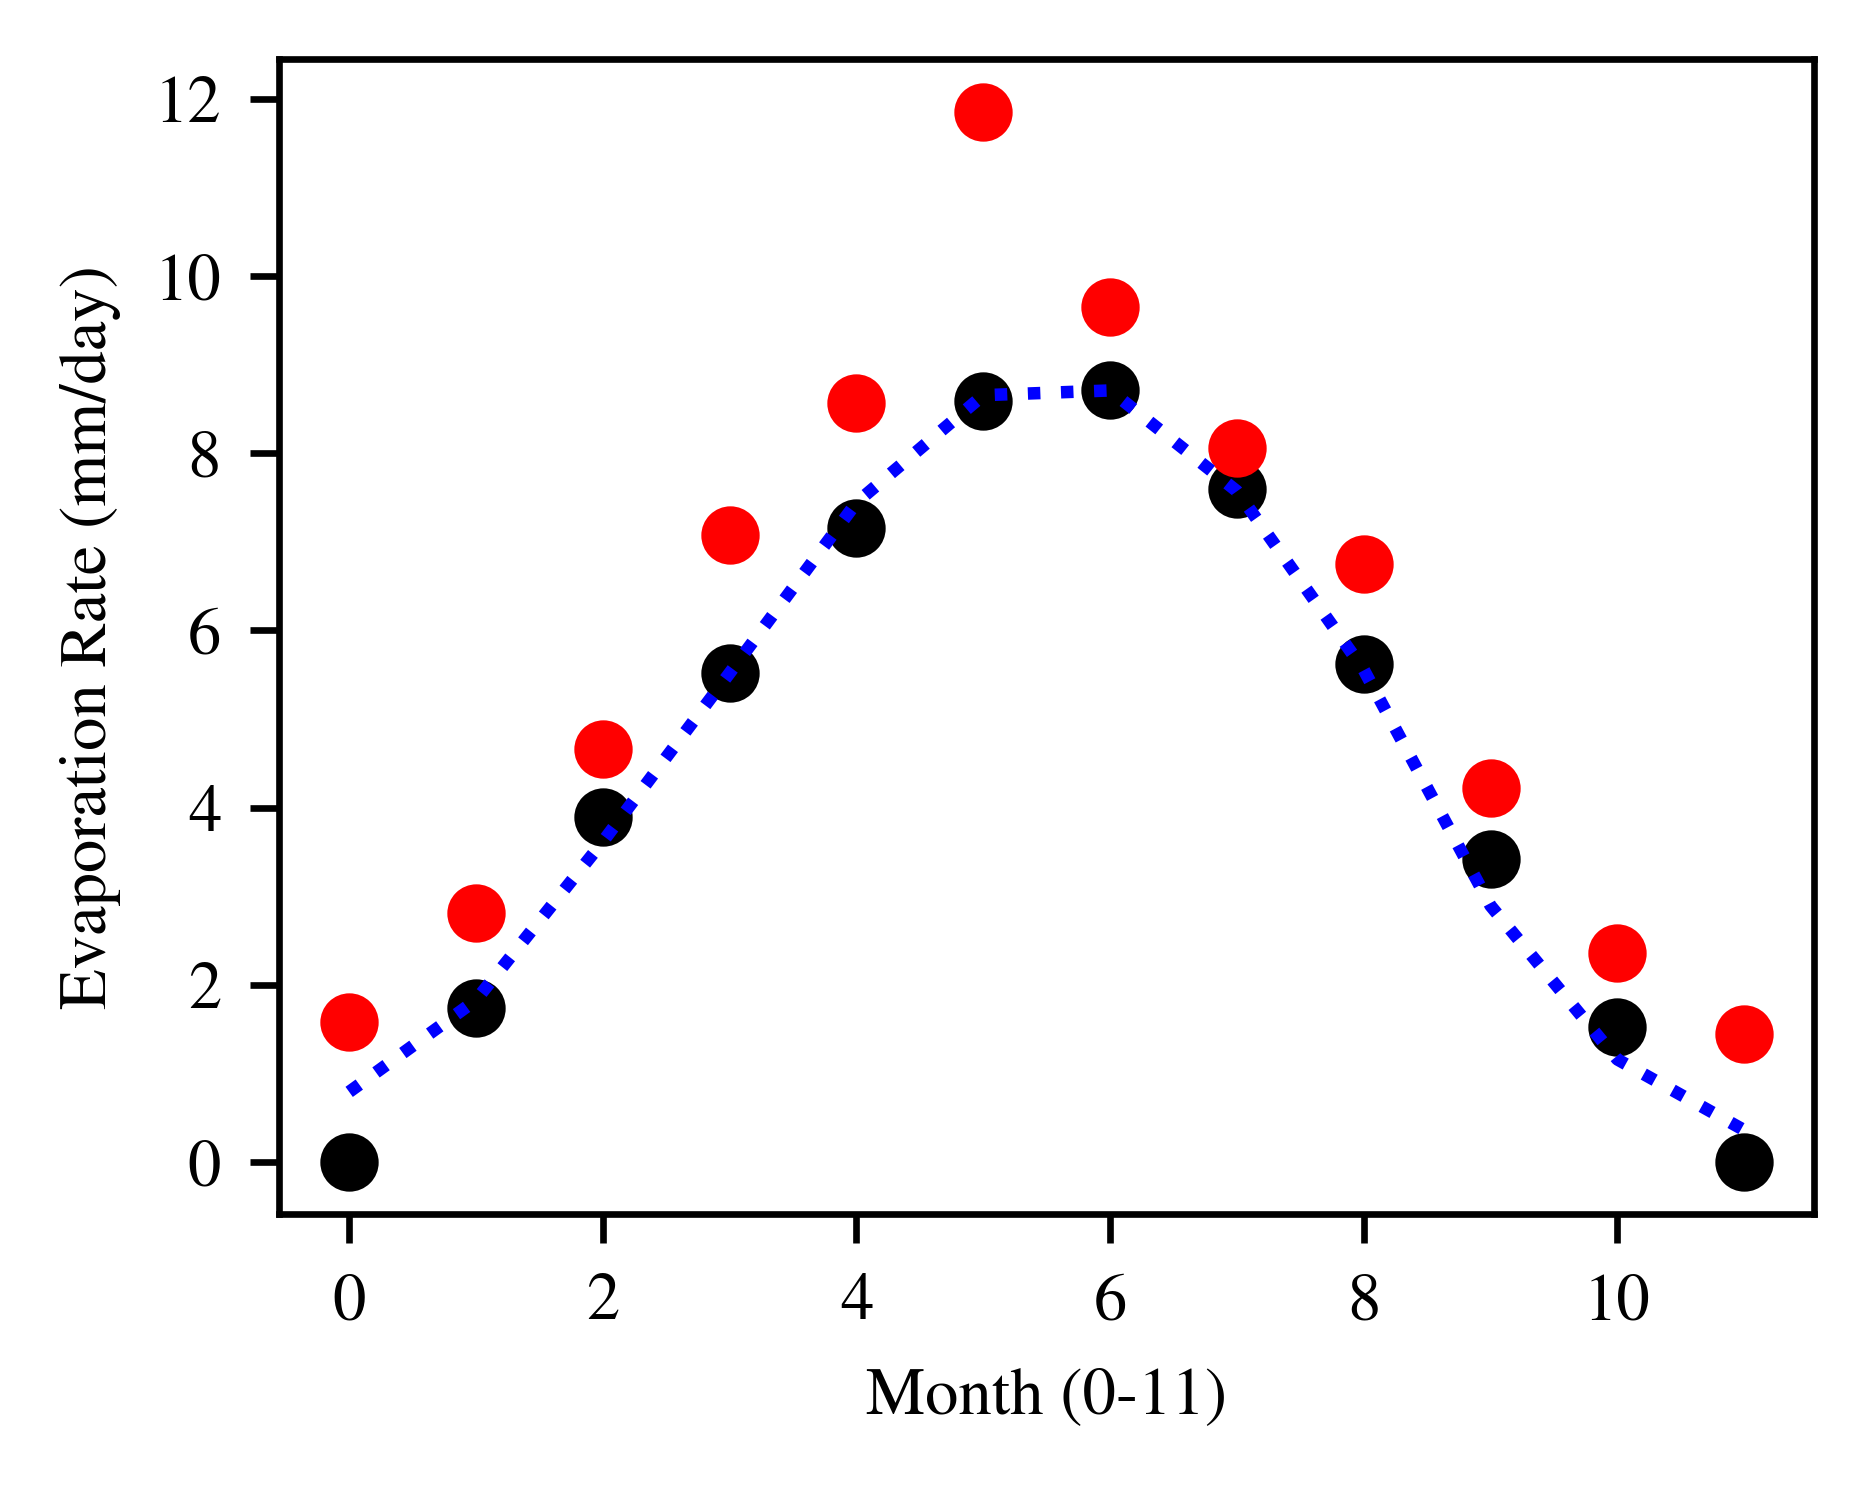

In [9]:
res_m_data = (
    res_m_df.groupby("month").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
)
pan_m_evap = pan_m_df.est.to_numpy()
popt = utils.get_fit_parameters(res_m_data, pan_m_evap)

print("Fitted Parameters: ", popt)
plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["est"].to_numpy(), "o")  # Pan estimations
plt.plot(res_m_mean_df.to_numpy(), "o")  # Model predictions
plt.plot(
    pan_m_df["month"].to_numpy() - 1,
    utils.evaporation_rate_curve(res_m_data, *popt),
    "b",
)

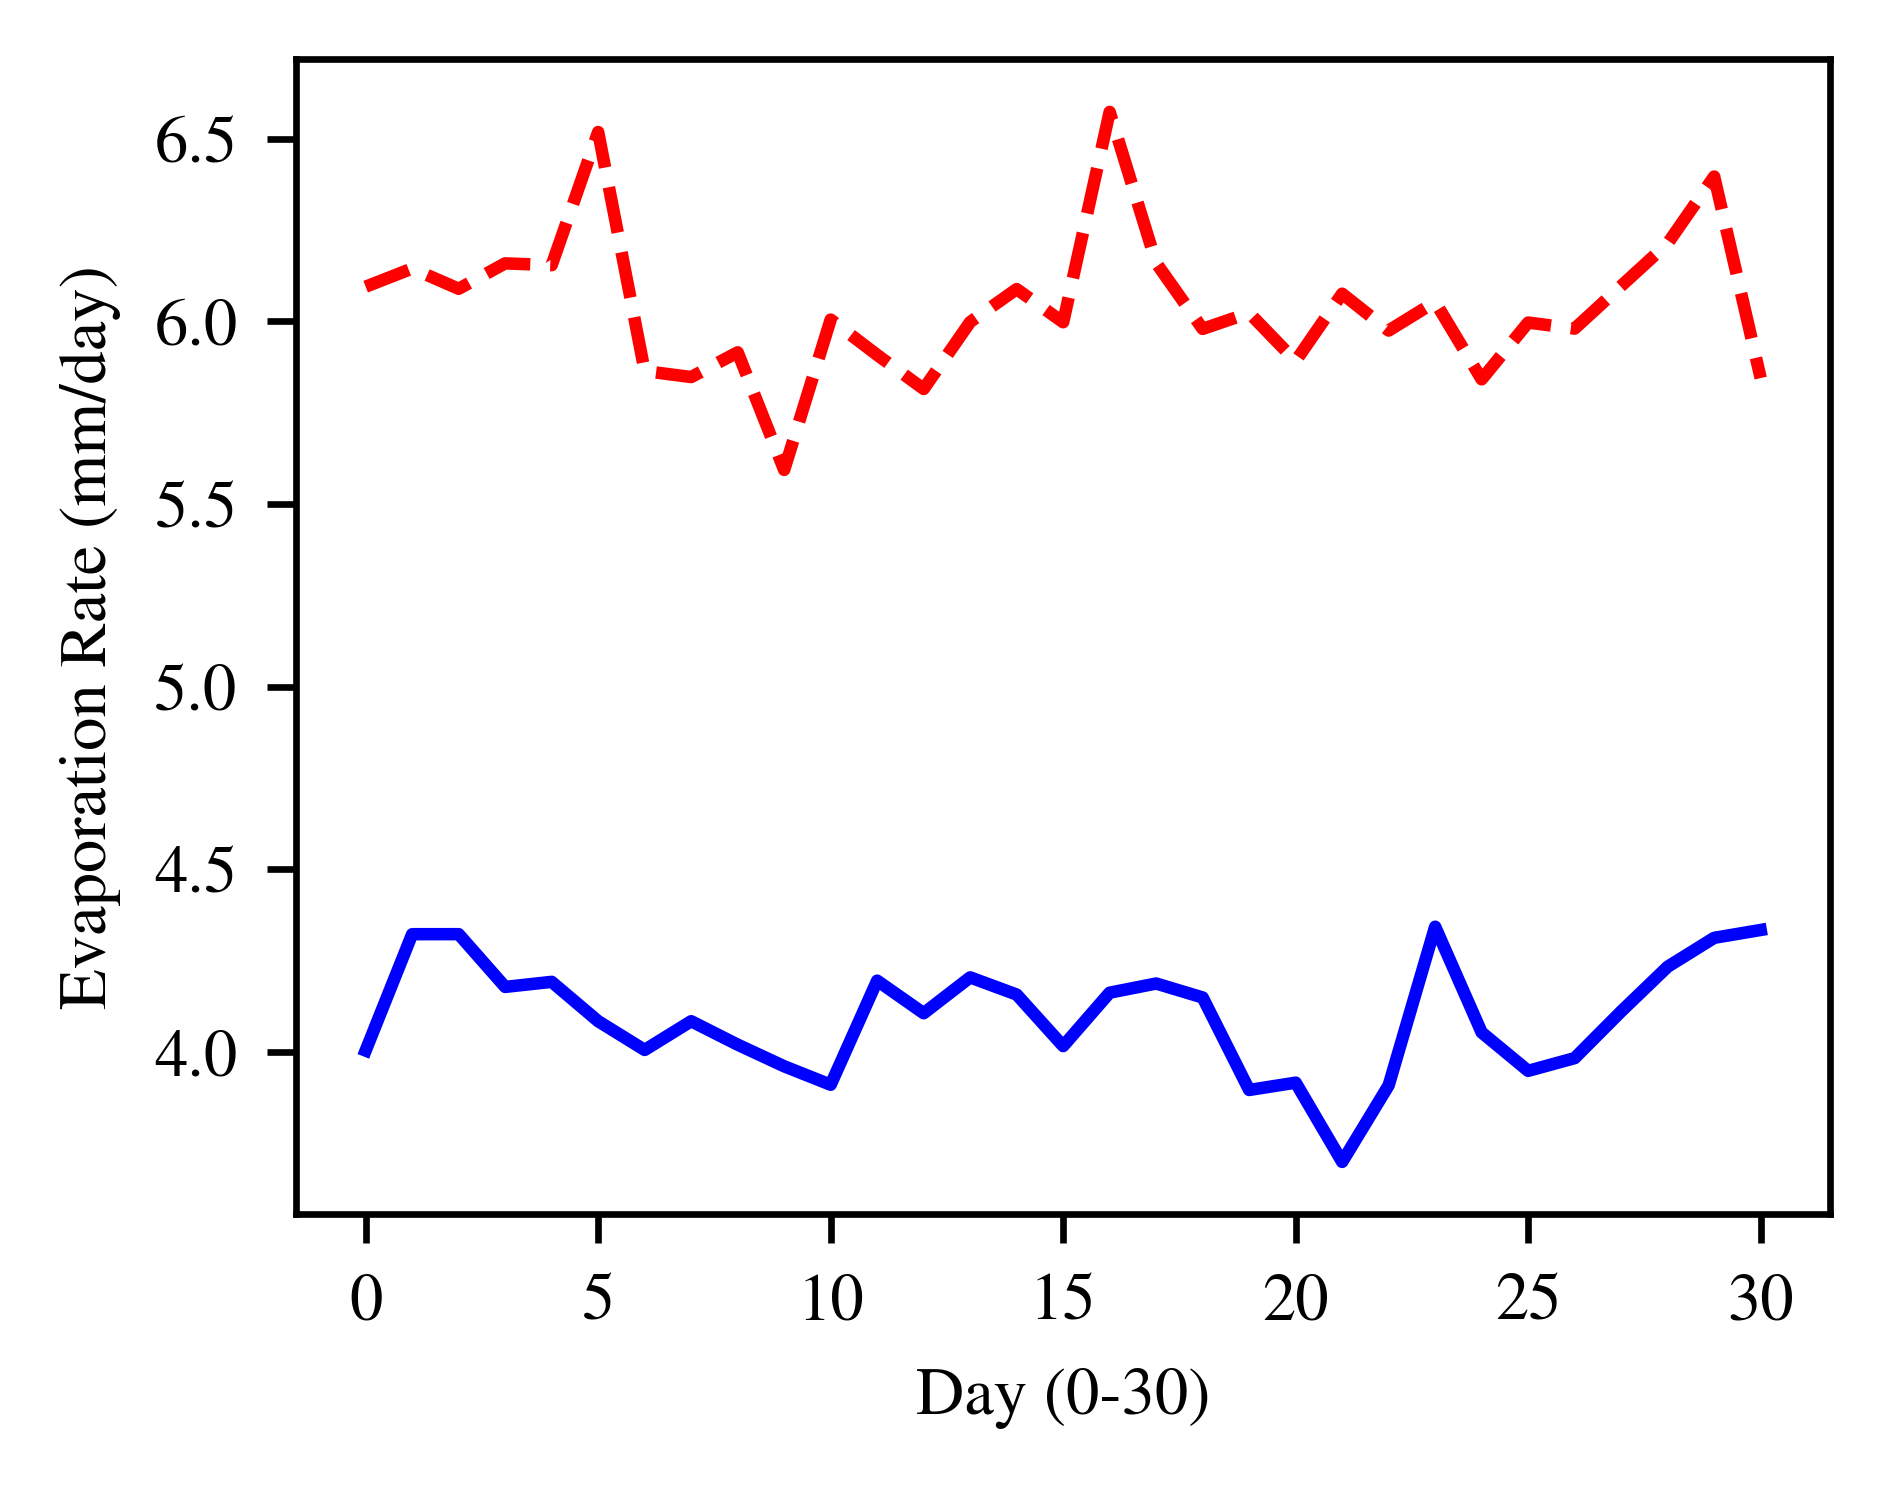

In [10]:
pga_d_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "D")
irr_d_df = utils.get_mean(irr_df, "time", ["G(i)"], "D")

res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

res_d_df["est"] = res_d_df.apply(
    lambda row: utils.get_evaporation_rate(
        row["tmpc"], row["dwpc"], ELEVATION, row["G(i)"], row["smps"]
    ),
    axis=1,
)

res_d_mean_df = res_d_df["est"].groupby(res_d_df["month"]).mean()
res_d_data = res_d_df.groupby("day").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
days = np.arange(res_d_data.shape[0])

plt.xlabel("Day (0-30)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(
    days, utils.evaporation_rate_curve(res_d_data, *popt), "b"
)  # Curve-fitted model
plt.plot(days, res_d_df["est"].groupby(res_d_df["day"]).mean(), "r")  # Original model

### Daily Average Rainfall and Evaporation


In [11]:
pga_d_df = utils.get_mean(pga_df, "valid", ["p01i", "tmpc", "dwpc", "smps"], "D")
irr_d_df = utils.get_mean(irr_df, "time", ["G(i)"], "D")
precip_d_df = utils.get_sum(pga_df, "valid", ["p01i"], "D")

res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

evap_d_data = (
    res_d_df.groupby(["month", "day"])
    .mean()[["tmpc", "dwpc", "G(i)", "smps"]]
    .to_numpy()
)

d_evap = utils.evaporation_rate_curve(evap_d_data, *popt)
d_precip = precip_d_df.groupby(["month", "day"]).mean()["p01i"].to_numpy()

print(d_evap.shape, d_precip.shape)

(366,) (366,)
